In [447]:
import numpy as np
import pandas as pd
import re
import krippendorff
from collections import defaultdict, Counter
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

In [448]:
#Fetching Data

df_mikkel = pd.read_json("annotations_mikkel.json")
df_david = pd.read_json("annotations_david.json")
df_carl = pd.read_json("annotations_carl.json")

#Fix of dataframe
def parse_label_string(label_str):
    return re.findall(r"'(.*?)'", label_str)

df_mikkel['original_label'] = df_mikkel['original_label'].apply(parse_label_string)

#Check:
df_mikkel["original_label"].iloc[0][0]

'None'

In [449]:
# Preparing data and setting variables 

num_encoder = {'None': 0,
               'Minimal': 1,
               'Basic': 2,
               'Good': 3,
               'Excellent': 4,
               '❗ Problematic Content ❗': 0, # for security
            }

N = len(df_mikkel)
R = 5 #number of ratings

score_dict = {}
score_data = []

for i in range(len(df_mikkel)):
    labels = [df_carl["our_label"].iloc[i], df_mikkel["our_label"].iloc[i], df_david["our_label"].iloc[i]] + df_mikkel["original_label"].iloc[i]
    scores = [num_encoder[label] for label in labels]
    id_ = df_mikkel["id"].iloc[i]
    score_dict[id_] = scores #dict of lists
    score_data.append(scores) # list of lists

/var/folders/t1/pvhvgdyj15g798qw31m8tb8c0000gn/T/ipykernel_52205/769216052.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


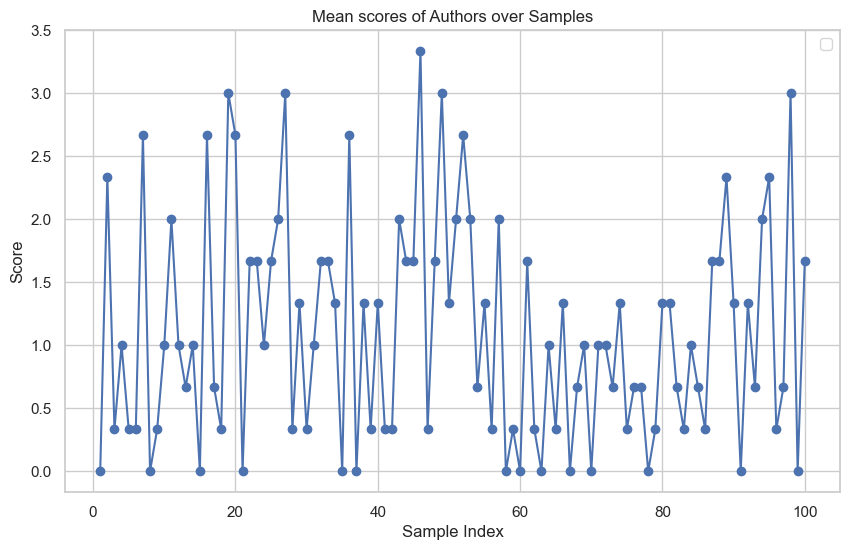

In [450]:
our_score_data = [scores[:3] for scores in score_data]  # Only our labels (Mikkel, David, Carl)

plt.figure(figsize=(10, 6))
plt.plot(range(1, N + 1), [np.mean(scores) for scores in our_score_data], marker='o')
plt.title('Mean scores of Authors over Samples')
plt.xlabel('Sample Index')
plt.ylabel('Score')
plt.legend()
plt.show()


____

## Global aggreement: MSD and Krippendorffs $\alpha$

### MSD

In [451]:

def Mean_Squared_Diff(score_data): # <-- list of lists

    SD_list = []

    for scores in score_data:
        c = len(scores)
        #The Squared Difference between unordered distinct pairs for one text:
        SD = (2 / (c * (c - 1))) * sum(
            (scores[j] - scores[k]) ** 2 
            for j in range(c) 
            for k in range(j+1,c))
        SD_list.append(SD)

    return np.mean(SD_list)

MSD = np.mean(Mean_Squared_Diff(score_data))

MSD

np.float64(1.2646666666666666)

### Krippendorff's $\alpha$

In [452]:
# Alpha calculated with library
def K_alpha(score_data,datatype):
    reliability_data = np.array(score_data).T 
    alpha = krippendorff.alpha(reliability_data=reliability_data, value_domain=list(range(R)), level_of_measurement=datatype)
    return alpha

alpha = K_alpha(score_data,"interval")
alpha

np.float64(0.4401220957303449)

In [453]:
#Alpha calculated by hand assuming equal intervals:

D_o = MSD

# All annotation scores
all_scores = np.asarray(score_data).flatten()


label_counts = Counter(all_scores)  #dict
labels = list(range(R))
n_total = len(all_scores)  # total annotations

# Calculate D_e
De_numerator = 0
for i in range(R):
    for j in range(i + 1, R):
        a = labels[i]
        b = labels[j]
        n_a = label_counts[a]
        n_b = label_counts[b]
        delta = (a - b) ** 2
        De_numerator += n_a * n_b * delta

D_e =  De_numerator * 2 / (n_total * (n_total - 1))

alpha_simplifed = 1 - D_o / D_e
alpha_simplifed

np.float64(0.4401220957303449)

In [454]:
#Comparing to ordinal delta function
alpha_ordinal = K_alpha(score_data, "ordinal")
diff_alpha = alpha - alpha_ordinal

print(f"alpha (interval): {alpha}")
print(f"alpha (ordinal): {alpha_ordinal}")
print(f"Difference (alpha - alpha_ordinal): {diff_alpha}")

alpha (interval): 0.4401220957303449
alpha (ordinal): 0.44388382293447715
Difference (alpha - alpha_ordinal): -0.003761727204132259


_______
## Comparing annotator-groups

In [455]:
n = 3 #number of author annotators

data = {"author": [scores[:n] for scores in score_data],
        "fineweb": [scores[n:] for scores in score_data],
        "all": score_data}

agreement = {}
for name,list_score in data.items():
    agreement[name] = (Mean_Squared_Diff(list_score), 
                       K_alpha(list_score, "ordinal"),
                       np.mean([np.mean(scores) for scores in list_score])
                       )
agreement

{'author': (np.float64(0.9666666666666666),
  np.float64(0.560818764498379),
  np.float64(1.106666666666667)),
 'fineweb': (np.float64(1.6066666666666665),
  np.float64(0.3381319866159098),
  np.float64(0.9500000000000002)),
 'all': (np.float64(1.2646666666666666),
  np.float64(0.44388382293447715),
  np.float64(1.0283333333333333))}

### Statistic tests

In [486]:
# Normality for MSD
from scipy.stats import shapiro

# first we define the MSD function:
def Squared_diff_list(score_data): # <-- list of lists

    SD_list = []

    for scores in score_data:
        c = len(scores)
        #The Squared Difference between unordered distinct pairs for one text:
        SD = (2 / (c * (c - 1))) * sum(
            (scores[j] - scores[k]) ** 2 
            for j in range(c) 
            for k in range(j+1,c))
        SD_list.append(SD)

    return SD_list

# Shapiro Wilk
stat, p_aut = shapiro(Squared_diff_list(data["author"]))
print(f"Shapiro-Wilk p 'author' = {p_aut}")

stat, p_fine = shapiro(Squared_diff_list(data["fineweb"]))
print(f"Shapiro-Wilk p 'fineweb' = {p_fine}")

np.mean(Squared_diff_list(score_data))

Shapiro-Wilk p 'author' = 5.730903158670814e-13
Shapiro-Wilk p 'fineweb' = 2.761921713048834e-10


np.float64(1.2646666666666666)

In [457]:
def hist_dist(sample1, sample2, name1, name2, type):
    sns.set(style="whitegrid")
    
    bins = [0.5 * x - 0.5 for x in range(16)]

    if type == "msd":
        list1 = Squared_diff_list(sample1)
        list2 = Squared_diff_list(sample2)

    elif type == "mean":
        list1 = [np.mean(scores) for scores in sample1]
        if sample2[0] is float:
            list2 = sample2
        else:
            list2 = [np.mean(scores) for scores in sample2]
        

    # Plot
    plt.figure(figsize=(8, 5))
    plt.hist(list1, bins=bins, edgecolor='black', color='skyblue', alpha=0.5, label=name1, rwidth=0.9)
    plt.hist(list2, bins=bins, edgecolor='black', color='salmon', alpha=0.5, label=name2, rwidth=0.9)

    # Customize axes
    plt.xlabel(type.upper() + ' Values')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Clean layout
    plt.tight_layout()
    plt.show()

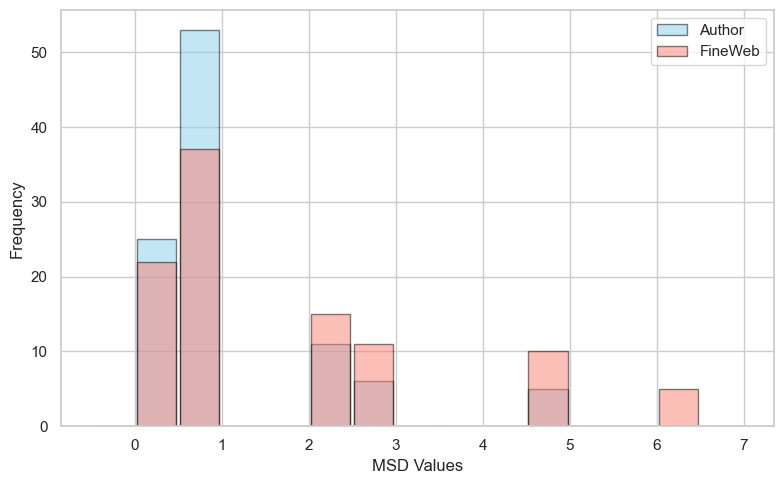

In [458]:
hist_dist(data["author"],data["fineweb"], "Author", "FineWeb", "msd")

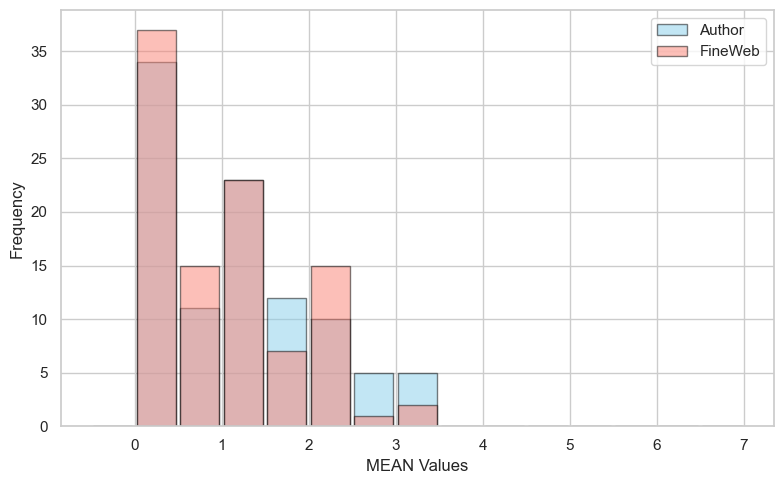

In [459]:
hist_dist(data["author"],data["fineweb"], "Author", "FineWeb", "mean")

In [460]:
#paired non-parametric test MSD
from scipy.stats import wilcoxon

def wilcoxon_test(sample1, sample2 , type):
    if type == "msd":
        list1 = Squared_diff_list(sample1)
        list2 = Squared_diff_list(sample2)

    elif type == "mean":
        if sample1[0] is float:
            list1 = sample1
        else:
            list1 = [np.mean(scores) for scores in sample1]
        if sample2[0] is float:
            list2 = sample2
        else:
            list2 = [np.mean(scores) for scores in sample2]
    else:
        "Error"
    #print(len(list1),len(list2))
    return wilcoxon(list1,list2) # returns --> wilcoxon_stat, wilcoxon_p$

In [461]:
# Paired test
wilcoxon_stat_msd, wilcoxon_p_msd = wilcoxon_test(data["author"], data["fineweb"], "msd")
wilcoxon_stat_mean, wilcoxon_p_mean = wilcoxon_test(data["author"], data["fineweb"], "mean")

print(f"Wilcoxon p-value (MSD): {wilcoxon_p_msd}")
print(f"Wilcoxon p-value (Mean): {wilcoxon_p_mean}")

Wilcoxon p-value (MSD): 0.0019335420818070834
Wilcoxon p-value (Mean): 0.024049874094710655


### Comparing our trained models

In [480]:
df_models = pd.read_json("../test/final_results.json", lines=True)

model_data = defaultdict(list)

raw_cols = [col for col in df_models.columns if col.startswith("raw")]
for col in raw_cols:
    model_data[col] = df_models[col].tolist()

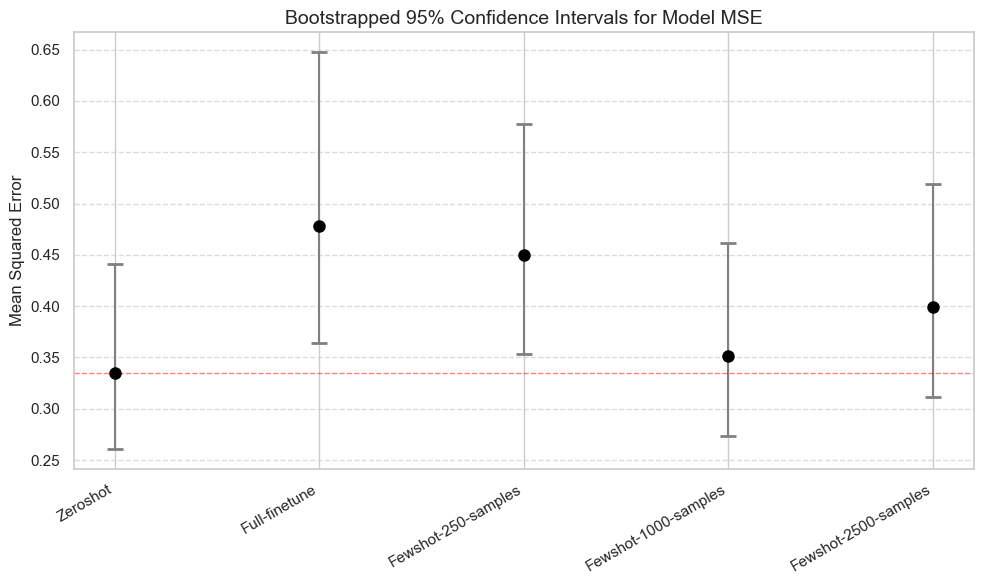

In [481]:
# Bootstrap confidence intervals for model MSEs

from scipy.stats import bootstrap

sns.set(style="whitegrid")

y_human = np.mean([np.mean(scores) for scores in score_data])

# Bootstrap parameters
n_bootstrap = 10000
alpha = 0.05

model_names = []
mean_errors = []
cis_lower = []
cis_upper = []

for name, predictions in model_data.items():
    preds = np.array(predictions)
    errors = (y_human - preds) ** 2

    model_names.append(name[15:].capitalize())

    res = bootstrap((errors,), np.mean, confidence_level=1 - alpha, 
                    n_resamples=n_bootstrap, method='bca')

    mean_errors.append(np.mean(errors))
    cis_lower.append(res.confidence_interval.low)
    cis_upper.append(res.confidence_interval.high)

mean_errors = np.array(mean_errors)
cis_lower = np.array(cis_lower)
cis_upper = np.array(cis_upper)

# Compute error bars
error_lower = mean_errors - cis_lower
error_upper = cis_upper - mean_errors
yerr = [error_lower, error_upper]

# Plotting
plt.figure(figsize=(10, 6))
colors = sns.color_palette("deep", len(model_names))

plt.errorbar(model_names, mean_errors, yerr=yerr,
             fmt='o', markersize=8, capsize=6, capthick=2,
             ecolor='gray', color='black', elinewidth=1.5)


plt.axhline(min(mean_errors), color='red', linestyle='--', linewidth=1, label='Best model MSE', alpha=0.5)

plt.title("Bootstrapped 95% Confidence Intervals for Model MSE", fontsize=14)
plt.ylabel("Mean Squared Error", fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#### Comparing to Human scores

In [464]:
# Checking for normality of human scores
shapiro_stat, shapiro_p = shapiro([np.mean(scores) for scores in score_data])
float(shapiro_p)

9.851985222541103e-05

No significance (p_shapiro < 0.05)  --> non-parametric tests

All models predicted significantly different scores than the human mean. (p-value > 0.05).

In [489]:
# MSD comparison with human scores

for name, scores in model_data.items():
    data_model_and_all = [[scores[i]] + data["all"][i] for i in range(len(scores))] 
    wilcoxon_stat, wilcoxon_p = wilcoxon_test(score_data, data_model_and_all, "msd")
    MSD_score = Mean_Squared_Diff(data_model_and_all)
    print(f"Model {name}, MSD: {MSD_score}, Wilcoxon p-value: {wilcoxon_p}")

Model raw_prediction_zeroshot, MSD: 1.3574493622668244, Wilcoxon p-value: 0.3271243358754563
Model raw_prediction_Full-finetune, MSD: 1.4133255572895491, Wilcoxon p-value: 0.14112810604636963
Model raw_prediction_fewshot-250-samples, MSD: 1.390700148578564, Wilcoxon p-value: 0.10535026094391692
Model raw_prediction_fewshot-1000-samples, MSD: 1.36255840799676, Wilcoxon p-value: 0.27573562109341054
Model raw_prediction_fewshot-2500-samples, MSD: 1.3776788986637056, Wilcoxon p-value: 0.19136101989145005


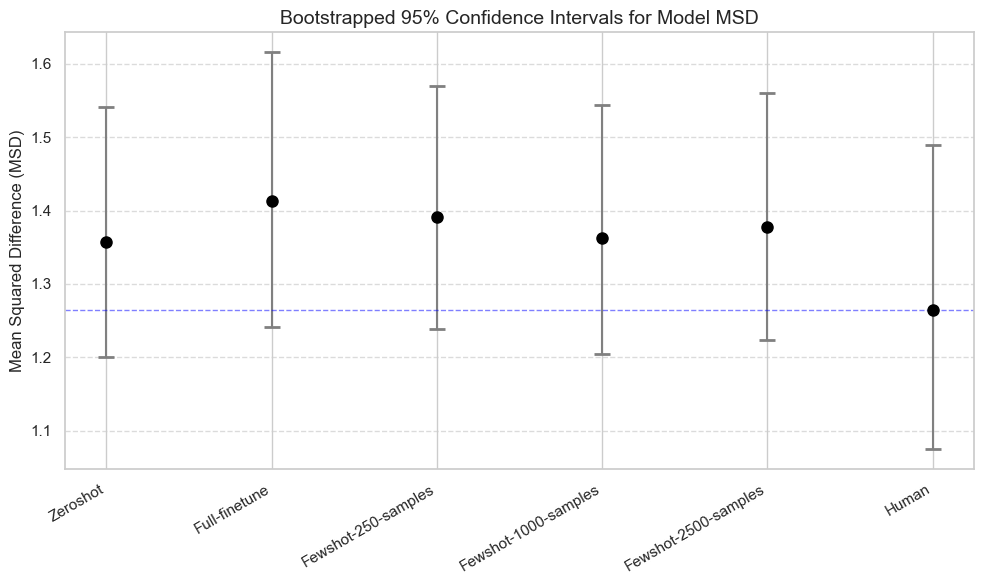

In [492]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bootstrap

# Plotting style
sns.set(style="whitegrid")

# Get the human baseline MSD
y_human = np.asarray(Squared_diff_list(score_data))

# Bootstrap parameters
n_bootstrap = 10000
alpha = 0.05

model_names = []
mean_errors = []
cis_lower = []
cis_upper = []

# Add raw human data as a baseline comparison
model_data_human = model_data.copy() 
model_data_human["Human"] = score_data

# Loop through models (and human baseline)
for name, predictions in model_data_human.items():
    # Format model name nicely
    model_names.append(name[15:].capitalize() if name != "Human" else "Human")

    if name != "Human":
        # Add model predictions to human ratings per sample
        combined = [np.append(score_data[i], predictions[i]) for i in range(len(predictions))]
    else:
        combined = score_data

    # Compute per-sample MSD
    y_all = np.asarray(Squared_diff_list(combined))

    # Bootstrap CI of the MSD
    res = bootstrap((y_all,), np.mean, confidence_level=1 - alpha, 
                    n_resamples=n_bootstrap, method='BCa')

    mean_errors.append(np.mean(y_all))
    cis_lower.append(res.confidence_interval.low)
    cis_upper.append(res.confidence_interval.high)

# Convert to arrays for plotting
mean_errors = np.array(mean_errors)
cis_lower = np.array(cis_lower)
cis_upper = np.array(cis_upper)

# Error bars
error_lower = mean_errors - cis_lower
error_upper = cis_upper - mean_errors
yerr = [error_lower, error_upper]

# --- Plotting ---
plt.figure(figsize=(10, 6))
colors = sns.color_palette("deep", len(model_names))

plt.errorbar(model_names, mean_errors, yerr=yerr,
             fmt='o', markersize=8, capsize=6, capthick=2,
             ecolor='gray', color='black', elinewidth=1.5)

# Optional: horizontal line for lowest MSD
plt.axhline(min(mean_errors), color='blue', linestyle='--', linewidth=1, label='Lowest MSD', alpha=0.5)

plt.title("Bootstrapped 95% Confidence Intervals for Model MSD", fontsize=14)
plt.ylabel("Mean Squared Difference (MSD)", fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

No models significantly raise the inter-annotator disagreement (MSD) when added the human annotators (p-values > 0.05). The MSD before the models where added was 1.26.

___
## Comparing classes
We create pools for each annotation class, including all items where a specific class was annotated at least once.

In [468]:
agreement_pools = {}
for i in range(R):
    pool = [scores for scores in data["all"] if i in scores]
    agreement_pools[i] = (Mean_Squared_Diff(pool), K_alpha(pool,"interval"), K_alpha(pool,"nominal"))
                        
    print(pool)

agreement_pools

[[0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 2], [2, 1, 0, 2, 0, 0], [1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 1, 0], [0, 0, 0, 1, 0, 1], [0, 1, 0, 0, 3, 0], [0, 2, 1, 2, 1, 3], [2, 2, 2, 0, 1, 3], [0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 1], [0, 2, 0, 2, 0, 0], [0, 1, 0, 1, 0, 1], [3, 3, 2, 0, 0, 2], [0, 0, 0, 0, 0, 0], [2, 2, 1, 0, 1, 3], [1, 2, 0, 0, 0, 0], [2, 3, 1, 1, 0, 3], [4, 3, 2, 0, 0, 1], [0, 1, 0, 1, 0, 2], [0, 1, 0, 0, 0, 0], [1, 2, 0, 3, 2, 1], [0, 2, 3, 1, 1, 1], [0, 0, 0, 0, 0, 1], [3, 4, 1, 3, 2, 0], [0, 0, 0, 0, 0, 0], [0, 3, 1, 0, 1, 2], [0, 1, 0, 0, 1, 0], [2, 2, 0, 0, 1, 3], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 1], [0, 1, 0, 1, 0, 0], [1, 2, 2, 0, 3, 1], [1, 2, 1, 1, 3, 0], [0, 1, 1, 0, 0, 0], [0, 1, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0], [0, 1, 0, 1, 1, 0], [0, 0, 0, 0, 1, 0], [1, 1, 3, 1, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 1, 2, 1, 0, 2], [0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 1, 0], [1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1], [1, 1, 1, 1, 0, 1], [1, 1, 1, 0, 0, 1],

{0: (np.float64(1.1981981981981982),
  np.float64(0.22475),
  np.float64(0.07934703347696381)),
 1: (np.float64(1.3450980392156862),
  np.float64(0.3109921898740673),
  np.float64(0.08497435840388046)),
 2: (np.float64(1.851190476190476),
  np.float64(0.219932763797273),
  np.float64(0.009585953256614044)),
 3: (np.float64(2.25),
  np.float64(0.11471659747521812),
  np.float64(-0.03136084679916662)),
 4: (np.float64(2.5380952380952375),
  np.float64(-0.017105414415450104),
  np.float64(-0.025458629726694104))}

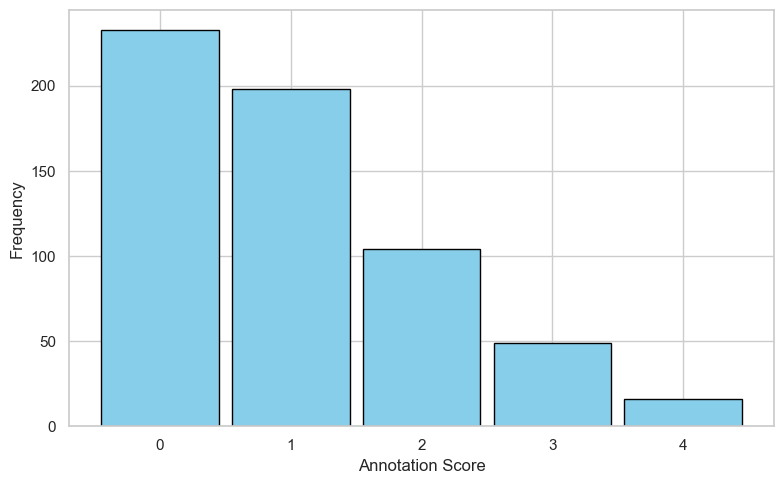

In [469]:
sns.set(style="whitegrid")

bins = [x - 0.5 for x in range(6)]

# Plot
plt.figure(figsize=(8, 5))
plt.hist(all_scores, bins=bins, edgecolor='black', color='skyblue', rwidth=0.9,)

# Customize axes
plt.xticks(range(5)) 
plt.xlabel('Annotation Score')
plt.ylabel('Frequency')

# Clean layout
plt.tight_layout()
plt.show()

In [470]:
def Mean_Ordinal_Diff(scores): # <— one item
    freqs = Counter(scores)
    categories = sorted(freqs.keys())
    total_pairs = 0
    total_OD = 0

    # Iterate over all unordered distinct pairs (a, b) where a < b
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            a, b = categories[i], categories[j]

            # Frequencies of a, b
            n_a = freqs[a]
            n_b = freqs[b]

            # Sum of frequencies between a and b (inclusive)
            n_sum = sum(freqs[g] for g in range(a, b + 1))

            # Ordinal difference formula
            delta_sq = (n_sum - (n_a + n_b) / 2) ** 2

            # Count how many such pairs exist
            pair_count = n_a * n_b
            total_OD += delta_sq * pair_count
            total_pairs += pair_count

    # Normalize by total number of unordered pairs
    if total_pairs > 0:
        return total_OD / total_pairs
    else:
        return 0